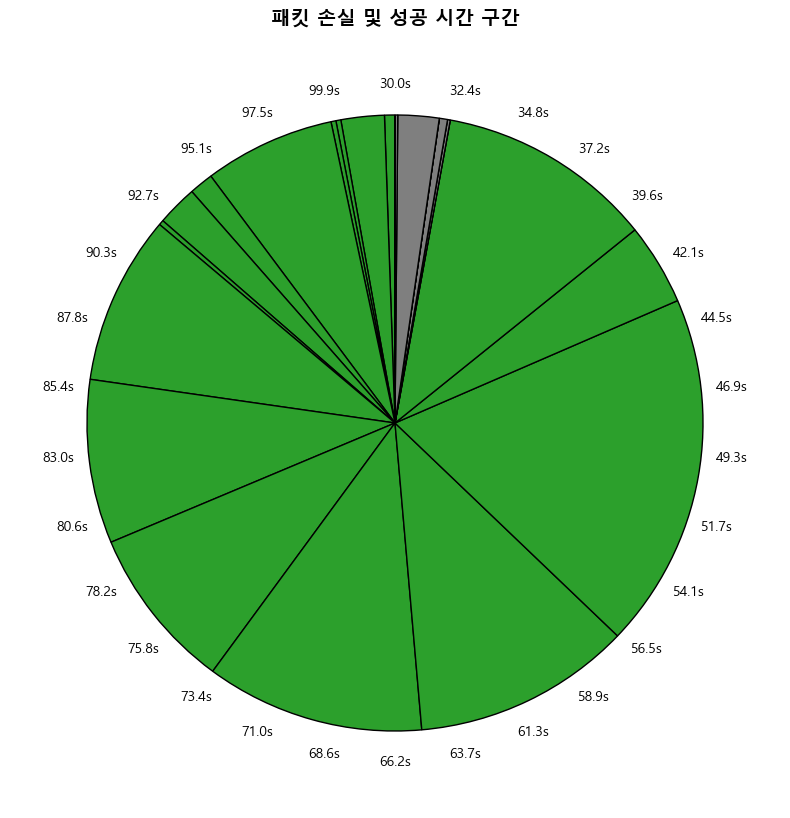

In [ ]:
import re
import time
import matplotlib.pyplot as plt
import numpy as np
import platform
from matplotlib import font_manager, rc

if platform.system() == 'Windows':
    rc('font', family='Malgun Gothic')

success_pings = {}
send_pings = {}

with open("success_app.txt", "r", encoding="utf-8") as file:
    for line in file:
        match = re.search(r'([\d.]+) : ping(\d+)-reply', line)
        if match:
            time_value = float(match.group(1))
            ping_num = int(match.group(2))
            success_pings[ping_num] = time_value

with open("sendPing.txt", "r", encoding="utf-8") as file:
    for line in file:
        match = re.search(r'([\d.]+):(\d+):', line)
        if match:
            time_value = float(match.group(1))
            ping_num = int(match.group(2))
            send_pings[ping_num] = time_value

file_read_end = time.time()
fail_pings = {ping: time for ping, time in send_pings.items() if ping not in success_pings}
fail_sequence_numbers = sorted(fail_pings.keys())

loss_ranges = []
start_seq = None
start_time = None

for i in range(len(fail_sequence_numbers)):
    seq_num = fail_sequence_numbers[i]
    ping_time = fail_pings[seq_num]

    if start_seq is None:
        start_seq = seq_num
        start_time = ping_time

    if i == len(fail_sequence_numbers) - 1 or fail_sequence_numbers[i + 1] != seq_num + 1:
        loss_ranges.append((start_seq, seq_num, start_time, ping_time))
        start_seq = None

success_ranges = []
prev_end_time = min(send_pings.values())

for start_seq, end_seq, start_time, end_time in loss_ranges:
    if prev_end_time < start_time:
        success_ranges.append((prev_end_time, start_time - 0.01))
    prev_end_time = end_time + 0.01

if prev_end_time <= max(send_pings.values()):
    success_ranges.append((prev_end_time, max(send_pings.values())))

labels = []
sizes = []
colors = []

for start_time, end_time in success_ranges:
    sizes.append(end_time - start_time)
    colors.append('#2ca02c')

for start_seq, end_seq, start_time, end_time in loss_ranges:
    sizes.append(end_time - start_time)
    colors.append('#7f7f7f')

fig, ax = plt.subplots(figsize=(10, 10))
wedges, texts = ax.pie(
    sizes, colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'}
)

min_time = min(send_pings.values())
max_time = max(send_pings.values())

num_labels = 30
time_intervals = np.linspace(min_time, max_time, num_labels)

for angle, label in zip(np.linspace(90, -270, num_labels, endpoint=False), time_intervals):
    x = np.cos(np.radians(angle)) * 1.1
    y = np.sin(np.radians(angle)) * 1.1
    ax.text(x, y, f"{label:.1f}s", ha='center', va='center', fontsize=10)

plt.title("패킷 손실 및 성공 시간 구간", fontsize=14, fontweight='bold', pad=10)
plt.show()